In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import warnings
""" We use this in order for the results to be more visible """ 
warnings.filterwarnings('ignore')

In [3]:
import nltk
import torch   
import random
import numpy as np
import matplotlib.pyplot as plt
import torchtext
import pandas as pd
import re
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import torch.nn as nn

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

We download the glove data set

In [4]:
EMBEDDING_SIZE = 300 
glove = torchtext.vocab.GloVe(name="42B", dim=EMBEDDING_SIZE) 

.vector_cache/glove.42B.300d.zip: 1.88GB [05:52, 5.32MB/s]                            
100%|█████████▉| 1917493/1917494 [03:30<00:00, 9104.09it/s]


We read the moview review data set and store it

In [5]:
df = pd.read_csv("/content/gdrive/MyDrive/AI2/project01/imdb-reviews.csv",sep='\t')

We implement the function that we use in order to prepare the data for prediction

In [6]:
def Preparation(dataframe):
  df = dataframe[['rating','review']]
  # Replace all rating values with either 1 or 0
  df = df.replace({
    'rating' : {
        1.0 : 0.0,
        2.0 : 0.0,
        3.0 : 0.0,
        4.0 : 0.0,
        7.0 : 1.0,
        8.0 : 1.0,
        9.0 : 1.0,
        10.0 : 1.0,  
    }
  })
  dummy_list = []

  # clean all stopwords and symbols from reviews using the clean function that we implemented
  text_column = df['review']
  for value in text_column.values:
    value = Clean(value)
    dummy_list.append(value)

  df['review'] = dummy_list

  # tokenize all reviews
  fixedReviews = Tokenization(df['review'])
  # apply stemming on all reviews
  fixedReviews = Stemming(fixedReviews)
  # lemmatize all reviews
  fixedReviews = Lemmatization(fixedReviews)

  df['review'] = fixedReviews

  return df

We implement a function that cleans up a review from all the stopwords and any symbol

In [7]:
stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
                           "]+", flags=re.UNICODE)

def Clean(review):
    if type(review) == np.float:
        return ""
    temp = review.lower()
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+","", temp) # remove mentions
    temp = re.sub("#[A-Za-z0-9_]+","", temp) # remove hashtags
    temp = re.sub(r'http\S+', '', temp) # remove links
    temp = re.sub(r"www.\S+", "", temp) # remove links
    temp = re.sub('[()!?]', ' ', temp) # remove punctuations 
    temp = re.sub('\[.*?\]',' ', temp) # remove punctuations 
    temp = re.sub("[^a-z0-9]"," ", temp) # remove non-alphanumeric characters
    temp = temp.split() # split text
    temp = [w for w in temp if not w in stopwords] # remove stopwords
    temp = " ".join(word for word in temp) # re-create text
    emoji_pattern.sub(r'', temp) # remove emojis and emoticons
    return temp

The following is a function that implements the process of Tokenization

In [8]:
def Tokenization(data):
  tokenizedReviews = []
  for value in data:
    value = nltk.sent_tokenize(value)
    tokenizedReviews.append(value)

  return tokenizedReviews

The following is a function that implements the process of Stemming

In [9]:
def Stemming(data):
  stemmer = SnowballStemmer(language = "english")

  stemmedReviews = []
  for value in data:
    dummyList = []
    for word in value:
      word = stemmer.stem(word)
      dummyList.append(word)
    stemmedReviews.append(dummyList)

  return stemmedReviews

The following is a function that implements the process of Lemmatization

In [10]:
def Lemmatization(data):
  lemmatizer = WordNetLemmatizer()

  lemmatizedReviews = []

  for value in data:
    value = ' '.join([lemmatizer.lemmatize(w) for w in value])
    lemmatizedReviews.append(value)

  return lemmatizedReviews

We use the preparation function that we implemented in order to get the data ready for the process

In [11]:
fixedDf = Preparation(df)

reviews = fixedDf['review'] #Keep everything but rating
ratings = fixedDf['rating'] #Only keep rating

In [12]:
fixedDf

,rating,review
0,1.0,thought quiet good movie fun watch liked best ...
1,1.0,wagon master unique film amongst john fords wo...
2,1.0,film near perfect film john ford made film mag...
3,0.0,gave 4 stars lot interesting themes many alrea...
4,1.0,movie really genuine random really hard find m...
...,...,...
45003,0.0,dont even know begin br br worth typing review...
45004,0.0,one worst movies saw 90s id often use benchmar...
45005,0.0,baldwin really stooped low make movies script ...
45006,0.0,liked watching mel gibson million dollar hotel...


We split the data in training and test set. Note for the grader: You can use the graders_data variable to store the data set you will need and then use the Preparation() function by just giving as input the variable. Then, you will only need to store the review column in the Y_train variable and the rating in the Y_test variable as implemented.

In [13]:
from sklearn.model_selection import train_test_split

graders_data = None

if(graders_data is not None):
  X_train = list(reviews)
  X_test = list(ratings)
  """ 
    Code needed in order to initialize Y_train and Y_test using graders_data 
    TODO: Use the Preparation function
  """
  graders_data = Preparation(graders_data)
  Y_train = list(graders_data['review'])
  Y_test = list(graders_data['rating'])
else:
  X_train, X_test, Y_train, Y_test = train_test_split(list(reviews), list(ratings), train_size=0.8)

We create our generator

In [14]:
g = torch.Generator()

The following function returns an array of the words inside the data, in order for us to use it in our implementation.

In [15]:
def getWords(data,labels,glove_vector):
    new_data = []
    for i, tweet in enumerate(data):
        idxs = [glove_vector.stoi[w] # We lookup for the index of every word
                for w in tweet.lower().split() # We split the review in tokens
                if w in glove_vector.stoi] # We keep the words that have an embedding
        if not idxs: # We ignore the tweets without any word with an embedding
            continue
        # We convert the list into tensor
        idxs = torch.tensor(idxs)
        label = torch.tensor(int(labels[i])).long()
        new_data.append((idxs, label))
    return new_data

The following class is our implementation for the batcher that we will use for our reviews. We use the tweets_by_length attribute as it can be used for our type of data as well, since we also have to work with word sentences.

In [16]:
class Batcher:
    def __init__(self, tweets, batch_size=32):
        self.tweets_by_length = {}
        for words, label in tweets:
            # We compute the length of the tweet
            wlen = words.shape[0]
            # We put the review in the correct key inside self.tweet_by_length depending on the length
            if wlen not in self.tweets_by_length:
                self.tweets_by_length[wlen] = []
            self.tweets_by_length[wlen].append((words, label),)
         
        #  We create a DataLoader for each set of reviews of the same length
        self.loaders = {wlen : torch.utils.data.DataLoader(
                                    tweets,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    worker_init_fn=seedWorker,
                                    generator=g,
                                    )
            for wlen, tweets in self.tweets_by_length.items()}
        
    def __iter__(self): 
        # We make an iterator for every review length
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            # We pick an iterator
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                iters.remove(im)

The following function is used in order to create the batchers needed, for the train and testing set given as parameters.

In [17]:
def createDataLoaders(trainSet,validSet,batch_size):
  return Batcher(trainSet, batch_size=batch_size), Batcher(validSet, batch_size=batch_size)

The following function is used in order to plot loss curves

In [18]:
def plotLossCurves(t_loss,v_loss,epochs = 100):
  x = list(range(1,epochs+1))
  plt.plot(x, t_loss, 'r',label='Train Loss')
  plt.plot(x, v_loss, 'g',label='Validation Loss')
  plt.legend(loc='best')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss vs Epoch curves')
  plt.show()

The following function initializes seeds for the workers of data loader

In [19]:
def seedWorker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  numpy.random.seed(worker_seed)
  random.seed(worker_seed)

The following function resets all random seeds

In [20]:
def resetSeeds():
  torch.manual_seed(0)
  np.random.seed(0)
  g.manual_seed(0)
  random.seed(0)

The following function is used in order to plot ROC curves

In [21]:
def plotRocCurves(model,test_loader):
  
  with torch.no_grad():
    # We set the model to evaluation mode
    model.eval()   
    y_total_test = []   
    y_total_predict_test = []      
    y_output = []
    # For every batch in the test loader
    for x_batch, y_batch in test_loader:
      x_batch = x_batch.to(device) 
      y_batch = y_batch.to(device)
      z = model(x_batch)
      # We get the label prediction based on the maximum posibility
      _, label = torch.max(z,1)    
      y_output = y_output + list(z.cpu().detach().numpy())
      # We store the predictions of the current batch
      y_total_predict_test = y_total_predict_test+ list(label.cpu()) 
      # We store the labels of the current batch
      y_total_test= y_total_test + list(y_batch.cpu().detach().numpy()) 


  fpr = {}
  tpr = {}
  thresh ={}

  y_output = np.array(y_output)
  noClasses = 3  

  # For every class
  for i in range(noClasses):    
      fpr[i], tpr[i], thresh[i] = roc_curve(y_total_test, y_output[:,i], pos_label=i)
      
  # We plot the ROC curves
  plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
  plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
  plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
  plt.title('Multiclass ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='best')
  plt.savefig('Multiclass ROC',dpi=300);  


  # We print the metrics results
  y_pred_tags = y_total_predict_test
  accuracy_countVec = accuracy_score(y_total_test,y_pred_tags)
  f1_score_countVec = f1_score(y_total_test,y_pred_tags,average='weighted')
  print(" Accuracy: %.2f%%" %(accuracy_countVec*100))
  print(" f1 score: %.2f%%" %(f1_score_countVec*100))
  print(' Precision: %.2f%%' % (precision_score(y_total_test, y_pred_tags,average='weighted')*100))
  print(' Recall: %.2f%%' % (recall_score(y_total_test, y_pred_tags,average='weighted')*100))
  print(classification_report(y_total_test, y_pred_tags))

The following function is used in order to plot the curves for the validation of our model as well as our metrics results.
In case the train parameter is given as True, we need to train the model and then do the validation, otherwise it means that we have an already trained model so we only need to plot the ROC curves and print the metrics results.

In [22]:
def Validation(model,device,num_epochs,train_loader,test_loader,train):
  # If we also need to train the model
  if(train is True):
    train_loss = []
    # For every epoch
    test_loss = []  
    for epoch in range(num_epochs):
      train_batch_losses = []
      test_batch_losses = [] 
      # We set the model to training mode
      model.train() 
      y_total_predict_train = []   
      y_total_train = []    
      train_loader_size = 0
      # For every batch in the train loader
      for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device) 
        y_batch = y_batch.to(device)
        # We delete any previously stored gradients
        optimizer.zero_grad()
        z = model(x_batch)
        # We compute the train loss
        loss = criterion(z, y_batch)  
        # We include the train loss of the current batch
        train_batch_losses.append(loss.data.item())
        # We perform backpropagation starting from the loss calculated in this epoch
        loss.backward()
        # We update the model's weights based on the gradients calculated during the process of backpropagation
        if gradient_clipping:
          for param in model.parameters():
            if param.grad is None:
                continue
            grad_val = torch.clamp(param.grad, -5, 5)
        optimizer.step()
        # We get the prediction based on the maximum posibility
        _, y_pred_tags = torch.max(z, dim = 1)  
        # We store the predictions of the current batch
        y_total_predict_train = y_total_predict_train+ list(y_pred_tags.cpu()) 
        # We store the labels of the current batch
        y_total_train = y_total_train + (list(y_batch.cpu().detach().numpy())) 
        train_loader_size += 1
      with torch.no_grad():
        correct = 0
        count = 0
        test_loader_count = 0
        # We set the model to evaluation mode
        model.eval()   
        y_total_test = []   
        y_total_predict_test = []     
        for x_batch, y_batch in test_loader:
          y_batch = y_batch.to(device) 
          x_batch = x_batch.to(device) 
          z = model(x_batch)
          # We compute the validation loss
          loss = criterion(z, y_batch)   
          # We update the validation loss of the current batch
          test_batch_losses.append(loss.data.item())
          # We get the label prediction based on the maximum posibility   
          _, label = torch.max(z,1)    
          # We compute how many corect preditions were made
          correct += (label==y_batch).sum().item()    
          count += len(y_batch)
          # We store the predictions of the current batch
          y_total_predict_test = y_total_predict_test+ list(label.cpu()) 
          # We store the labels of the current batch
          y_total_test= y_total_test + list(y_batch.cpu().detach().numpy()) 
          test_loader_count += 1
      # We compute the validation accuracy based on the correct predictions
      accuracy = 100*(correct/(count))  
      # We compute the train loss of this epoch
      current_train_loss = sum(train_batch_losses)/train_loader_size  
      # We store the train loss in order to plot loss curves
      train_loss.append(current_train_loss)   
      # We compute the validation loss of this epoch
      current_test_loss = sum(test_batch_losses)/test_loader_count   
      # We store the validation loss in order to plot loss curves
      test_loss.append(current_test_loss)   
      # We compute the train f1-score
      f1_score_train = f1_score(y_total_train,y_total_predict_train,average='weighted')
      # We compute the validation f1-score
      f1_score_test = f1_score(y_total_test,y_total_predict_test,average='weighted') 
      print(f"Epoch {epoch:3}: Train Loss = {current_train_loss:.5f} | Validation Loss = {current_test_loss:.5f} | Accuracy = {accuracy:.4f} | Train-f1 = {f1_score_train:.4f} | Valid-F1 = {f1_score_test:.4f}")

    # We plot the loss vs epochs curves
    plotLossCurves(train_loss,test_loss,num_epochs) 

  # We plot the ROC curves as well as the metrics results.
  plotRocCurves(model,test_loader)

The following class is my implementation for the best LSTM model which includes:

*   Two stacked LSTM bidirectional layers with hidden size = 8
*   Dropout between the layers
*   Gradient clipping





In [23]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_between_layers, final_dropout,bidirectional):
        super(RNN, self).__init__()
        self.num_layers = num_layers 
        self.hidden_size = hidden_size 
        self.emb = nn.Embedding.from_pretrained(glove.vectors) 
        # In case we only have one layer, the dropout between stacked layers is not defined
        if(num_layers==1):
          dropout_between_layers = 0
        if model_type=='LSTM': 
          # We define the stacked bidirectional LSTM layers
          self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_between_layers,bidirectional=bidirectional)
        elif model_type=='GRU': 
          self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_between_layers,bidirectional=bidirectional)
        # Otherwise we define a classic RNN cell
        else: 
          self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_between_layers,bidirectional=bidirectional)

        self.dropout = nn.Dropout(final_dropout) 
        self.fc = nn.Linear(hidden_size*2, num_classes) 
        
        # We initialize all the weights
        self._init_weights() 
        
    def forward(self, x):
        # We create the embeddings of the reviews
        x = self.emb(x) 
        # We set the initial hidden states
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) 
        if model_type=='LSTM':
          # Set initial cell states for LSTM
          c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
          # We set the lstm stacked bidirectional layers
          out, _ = self.lstm(x, (h0,c0))  
        elif model_type=='GRU':
          # We set the gru stacked bidirectional layers
          out, _ = self.gru(x, h0)  
        else:
          out, _ = self.rnn(x, h0) 
        
        # We set the dropout after the last LSTM/GRU layer
        out = self.dropout(out)
        # We reshape the output 
        out = out[:, -1, :] 
         
        # We set linear output layer, in order to create output of size 3 (number of classes).
        out = self.fc(out) 
        return out
    
    # The following is a function that initializes all the model weights
    def _init_weights(self):
        if model_type=='LSTM':
          params = self.lstm.parameters()
        elif model_type=='GRU':
          params = self.gru.parameters()
        else:
          params = self.rnn.parameters()
        for param in params:
            # We keep track of gradient for backprop
            param.requires_grad_(True)
            # If we have to deal with weights, then we use xavier initialization
            if param.data.ndimension() >= 2:
                nn.init.xavier_uniform_(param.data) #keep variance stability
            # Otherwise it is a bias term, so we set to zeros
            else: 
                nn.init.zeros_(param.data)

We initialize our model with the following hyperparameters:


*   Number of classes 3
*   Number of epochs 30
*   Batch size 16
*   Learning rate 0.000125



In [24]:
# We configure the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)
np.random.seed(0)
g.manual_seed(0)
# We reset all seeds
random.seed(0) 
num_classes = 3
num_epochs = 30
batch_size = 16
learning_rate = 0.000125

input_size = EMBEDDING_SIZE
hidden_size = 8
num_layers = 2
dropout_between_layers = 0.6
final_dropout = 0.5
gradient_clipping = True
bidirectional = True

# We tokenize the train set and convert the words to the corresponding embedding index
train_set_transformed = getWords(X_train,Y_train,glove) 
# We tokenize the validation set and convert the words to the corresponding embedding index
test_set_transformed = getWords(X_test,Y_test,glove) 

# We set the model type to LSTM
model_type = 'LSTM'
# We create the batchers and DataLoaders for the train and the validation set
train_loader, test_loader = createDataLoaders(train_set_transformed, test_set_transformed,batch_size)
# We initialize the model
model_lstm = RNN(input_size, hidden_size, num_layers, num_classes,dropout_between_layers,final_dropout,bidirectional).to(device)
print(model_lstm)
# We initialize the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=learning_rate)

RNN(
  (emb): Embedding(1917494, 300)
  (lstm): LSTM(300, 8, num_layers=2, batch_first=True, dropout=0.6, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=16, out_features=3, bias=True)
)


We validate our model. 
**Note:** This cell will probably take hours to execute. For this reason in the following cell we load the pre-trained model that I have included in my exercise and Validate it using the train and validation loaders. Please do execute the next cell and **NOT THIS ONE** 

Epoch   0: Train Loss = 0.82585 | Validation Loss = 0.69166 | Accuracy = 66.7518 | Train-f1 = 0.5039 | Valid-F1 = 0.6648
Epoch   1: Train Loss = 0.60550 | Validation Loss = 0.49708 | Accuracy = 80.2599 | Train-f1 = 0.7062 | Valid-F1 = 0.8021
Epoch   2: Train Loss = 0.49654 | Validation Loss = 0.46182 | Accuracy = 82.1040 | Train-f1 = 0.8030 | Valid-F1 = 0.8201
Epoch   3: Train Loss = 0.46211 | Validation Loss = 0.40883 | Accuracy = 84.3812 | Train-f1 = 0.8236 | Valid-F1 = 0.8438
Epoch   4: Train Loss = 0.43174 | Validation Loss = 0.39700 | Accuracy = 85.0255 | Train-f1 = 0.8336 | Valid-F1 = 0.8503
Epoch   5: Train Loss = 0.41109 | Validation Loss = 0.36978 | Accuracy = 85.9920 | Train-f1 = 0.8448 | Valid-F1 = 0.8599
Epoch   6: Train Loss = 0.39777 | Validation Loss = 0.34853 | Accuracy = 86.3919 | Train-f1 = 0.8488 | Valid-F1 = 0.8639
Epoch   7: Train Loss = 0.38053 | Validation Loss = 0.35506 | Accuracy = 86.6807 | Train-f1 = 0.8550 | Valid-F1 = 0.8668
Epoch   8: Train Loss = 0.36777 

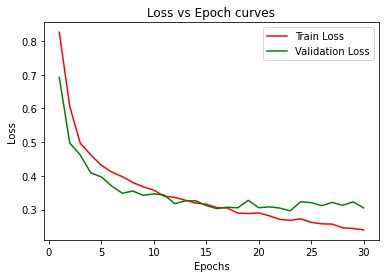

 Accuracy: 89.08%
 f1 score: 89.08%
 Precision: 89.11%
 Recall: 89.08%
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      4449
           1       0.88      0.91      0.89      4553

    accuracy                           0.89      9002
   macro avg       0.89      0.89      0.89      9002
weighted avg       0.89      0.89      0.89      9002



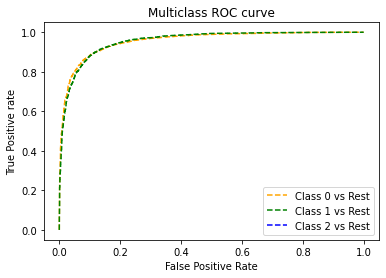

In [ ]:
# We validate the model and then save it
Validation(model_lstm,device,num_epochs,train_loader,test_loader,True)
torch.save(model_lstm.state_dict(),"model.pt")

To load the pre-trained model you just have to change the variable pathToModel in order to load the correct model from the location in your system.

 Accuracy: 91.32%
 f1 score: 91.31%
 Precision: 91.47%
 Recall: 91.32%
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      4554
           1       0.94      0.88      0.91      4448

    accuracy                           0.91      9002
   macro avg       0.92      0.91      0.91      9002
weighted avg       0.91      0.91      0.91      9002



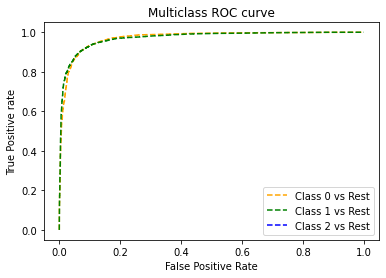

In [29]:
""" TODO: Change me """
pathToModel = "/model.pt"

device = torch.device('cpu')
model_lstm.load_state_dict(torch.load(pathToModel,map_location=device))

Validation(model_lstm,device,num_epochs,train_loader,test_loader,False)

The following class is my implementation for the best GRU model which includes:

*   Two stacked LSTM bidirectional layers with hidden size = 8
*   Dropout between the layers
*   Gradient clipping
*   Skip connections

In [25]:
# the RNN implementation
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_between_layers, final_dropout,bidirectional):
        super(RNN, self).__init__()
        self.num_layers = num_layers 
        self.hidden_size = hidden_size 
        self.emb = nn.Embedding.from_pretrained(glove.vectors) 
        # If we only have one layer, the dropout between stacked layers is not defined
        if(num_layers==1): 
          dropout_between_layers = 0
        if model_type=='LSTM': 
          # We implement 2 stacked LSTM layers
          # We initialize the first LSTM layer
          self.lstm1 = nn.LSTM(input_size, hidden_size, 1, batch_first=True,bidirectional=bidirectional) 
          # We initialize the dropout between the stacked LSTM layers
          self.dropout_between_layers = nn.Dropout(dropout_between_layers) 
          # We initialize the second LSTM layer
          self.lstm2 = nn.LSTM(2*hidden_size, hidden_size, 1, batch_first=True,bidirectional=bidirectional)
        elif model_type=='GRU': 
          # We implement 2 stacked GRU layers
          # We initialize the first GRU layer
          self.gru1 = nn.GRU(input_size, hidden_size, 1, batch_first=True,bidirectional=bidirectional) 
          # We initialize the dropout between the stacked GRU layers
          self.dropout_between_layers = nn.Dropout(dropout_between_layers) 
          # We initialize the second GRU layer
          self.gru2 = nn.GRU(2*hidden_size, hidden_size, 1, batch_first=True,bidirectional=bidirectional) 
      
        # We initialize the dropout layer after the last LSTM/GRU layer
        self.dropout = nn.Dropout(final_dropout) 
        # If we apply skip connections
        if skip_connections: 
          # Then the input of the linear output layer is 2 times the output of the LSTM/GRU layer 
          self.fc = nn.Linear(hidden_size*2*2, num_classes)
        else:
          # Otherwise we initialize the linear output layer
          self.fc = nn.Linear(hidden_size*2, num_classes)  
        
        # We initialize all the weights
        self._init_weights() 
        
    def forward(self, x):
        # We create the embeddings of the tweets    
        x = self.emb(x) 
        # We set initial hidden states
        h0 = torch.zeros(2, x.size(0), self.hidden_size).to(device) 
        if model_type=='LSTM':
          # Set initial cell states for LSTM
          c0 = torch.zeros(2, x.size(0), self.hidden_size).to(device)
          # We apply the first LSTM layer and save the output
          out_lstm1, (h1,c1) = self.lstm1(x, (h0,c0)) 
          # We apply dropout after the first LSTM layer
          out_lstm1 = self.dropout_between_layers(out_lstm1) 
          # We apply the second LSTM layer (giving the output of the first LSTM layer as input) and save the output
          out_lstm1_2, _ = self.lstm2(out_lstm1, (h0,c0)) 
          out =  out_lstm1_2
        elif model_type=='GRU':
          # We apply the first GRU layer and save the output
          out_gru1, _ = self.gru1(x, h0) 
          # We apply dropout after the first GRU layer
          out_gru1 = self.dropout_between_layers(out_gru1) 
          # We apply the second GRU layer (giving the output of the first GRU layer as input) and save the output
          out_gru2, _ = self.gru2(out_gru1, h0)
          out = out_gru2
        
        # If we want to apply skip connections
        if skip_connections and model_type=='LSTM': 
          # We concatenate the output of the first LSTM layer and the output of the second LSTM layer
          out = torch.cat([out, out_lstm1], dim=2)
        elif skip_connections and model_type=='GRU': # if we want to apply skip connections
          # We concatenate the output of the first GRU layer and the output of the second GRU layer
          out = torch.cat([out, out_gru1], dim=2)
        # We apply dropout to the concatenated output
        out = self.dropout(out) 
        # We reshape the output
        out = out[:, -1, :]
        # We initialize the linear output layer, in order to create output of size 3 (number of classes). 
        out = self.fc(out) 
        return out
    
    # The following is a function that initializes all the model weights
    def _init_weights(self):
        if model_type=='LSTM':
          layers = [ self.lstm1 , self.lstm2 ]
        elif model_type=='GRU':
          layers = [ self.gru1 , self.gru2 ]
        for layer in layers:
          for param in layer.parameters():
              # We keep track of the gradient for backpropagation
              param.requires_grad_(True)
              # If we deal with weights, then we use xavier initialization
              if param.data.ndimension() >= 2:
                  # We keep variance stability
                  nn.init.xavier_uniform_(param.data) 
              else: 
                nn.init.zeros_(param.data)

We initialize our model with the following hyperparameters:

*  Number of classes 3
*  Number of epochs 30
*  Batch size 16
*  Learning rate 0.0001

In [26]:
# We configure the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# We reset all seeds
resetSeeds()
num_classes = 3
num_epochs = 30
batch_size = 16
learning_rate = 0.0001

input_size = EMBEDDING_SIZE
hidden_size = 8
num_layers = 2
dropout_between_layers = 0.5
final_dropout = 0.25
gradient_clipping = True
bidirectional = True
skip_connections = True

# We tokenize the train set and convert the words to the corresponding embedding index
train_set_transformed = getWords(X_train,Y_train,glove) 
# We tokenize the validation set and convert the words to the corresponding embedding index
test_set_transformed = getWords(X_test,Y_test,glove) 

# We set the model type to GRU
model_type = 'GRU'
# We create the batchers and DataLoaders for the train and the validation set
train_loader, test_loader = createDataLoaders(train_set_transformed, test_set_transformed,batch_size)
# We initialize the model
model_gru = RNN(input_size, hidden_size, num_layers, num_classes,dropout_between_layers,final_dropout,bidirectional).to(device)
print(model_gru)
# We initialize the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_gru.parameters(), lr=learning_rate)

RNN(
  (emb): Embedding(1917494, 300)
  (gru1): GRU(300, 8, batch_first=True, bidirectional=True)
  (dropout_between_layers): Dropout(p=0.5, inplace=False)
  (gru2): GRU(16, 8, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=32, out_features=3, bias=True)
)


We validate our model. 
**Note:** This cell will probably take hours to execute. For this reason in the following cell we load the pre-trained model that I have included in my exercise and Validate it using the train and validation loaders. Please do execute the next cell and **NOT THIS ONE** 

Epoch   0: Train Loss = 0.79242 | Validation Loss = 0.68681 | Accuracy = 61.8529 | Train-f1 = 0.5128 | Valid-F1 = 0.5981
Epoch   1: Train Loss = 0.65559 | Validation Loss = 0.56140 | Accuracy = 76.1609 | Train-f1 = 0.6215 | Valid-F1 = 0.7616
Epoch   2: Train Loss = 0.48423 | Validation Loss = 0.39740 | Accuracy = 84.2479 | Train-f1 = 0.7944 | Valid-F1 = 0.8425
Epoch   3: Train Loss = 0.39884 | Validation Loss = 0.37262 | Accuracy = 85.5254 | Train-f1 = 0.8435 | Valid-F1 = 0.8552
Epoch   4: Train Loss = 0.35939 | Validation Loss = 0.35528 | Accuracy = 86.4697 | Train-f1 = 0.8580 | Valid-F1 = 0.8647
Epoch   5: Train Loss = 0.33964 | Validation Loss = 0.36092 | Accuracy = 86.6807 | Train-f1 = 0.8655 | Valid-F1 = 0.8667
Epoch   6: Train Loss = 0.32084 | Validation Loss = 0.35328 | Accuracy = 86.9918 | Train-f1 = 0.8726 | Valid-F1 = 0.8698
Epoch   7: Train Loss = 0.30475 | Validation Loss = 0.33802 | Accuracy = 87.4917 | Train-f1 = 0.8797 | Valid-F1 = 0.8749
Epoch   8: Train Loss = 0.29591 

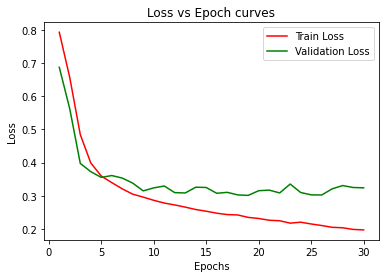

 Accuracy: 89.07%
 f1 score: 89.07%
 Precision: 89.15%
 Recall: 89.07%
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      4449
           1       0.91      0.87      0.89      4553

    accuracy                           0.89      9002
   macro avg       0.89      0.89      0.89      9002
weighted avg       0.89      0.89      0.89      9002



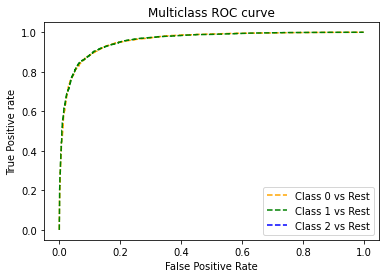

In [27]:
# We validate the model and then save it
Validation(model_gru,device,num_epochs,train_loader,test_loader,True)
torch.save(model_gru.state_dict(),"model2.pt")

To load the pre-trained model you just have to change the variable pathToModel in order to load the correct model from the location in your system.

 Accuracy: 92.08%
 f1 score: 92.07%
 Precision: 92.14%
 Recall: 92.08%
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      4554
           1       0.94      0.90      0.92      4448

    accuracy                           0.92      9002
   macro avg       0.92      0.92      0.92      9002
weighted avg       0.92      0.92      0.92      9002



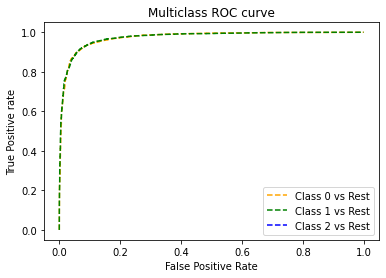

In [32]:
""" TODO: Change me """
pathToModel = "/model2.pt"

device = torch.device('cpu')
model_gru.load_state_dict(torch.load(pathToModel,map_location=device))

Validation(model_gru,device,num_epochs,train_loader,test_loader,False)